In [349]:
import pandas as pd
import numpy as np
import akshare as ak
from datetime import datetime
from tqdm import tqdm
from typing import List, Optional
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import empyrical as ep

# TSMOM因子计算

参考：  
https://zhuanlan.zhihu.com/p/60802784  
https://zhuanlan.zhihu.com/p/120835716  
Moskowitz T J, Ooi Y H, Pedersen L H. Time series momentum[J]. Journal of financial economics, 2012, 104(2): 228-250.

### 数据处理

读取收盘价数据，并进行检查

In [2]:
#字段管理
fields = {
    'S_DQ_ADJCLOSE': 'close',
    'S_INFO_WINDCODE': 'stkcd',
    'TRADE_DT': 'date',
    'S_DQ_VOLUME': 'volume',
    '收盘': 'close',
    '日期': 'date',
    'Stkcd': 'stkcd',
    'F100101B': 'PE_1',
    'F100102B': 'PE_2',
    'F100103C': 'PE_TTM',
    'F100801A': 'MkV_A',
    'F100802A': 'MKV_B',
    'F101001A': 'BM_A',
    'F101002A': 'BM_B',
    '报告日': 'date',
    '利率': 'interest'
}

#读取数据的预处理
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    del df['Unnamed: 0']
    df.rename(columns=fields, inplace=True)
    df['date'] = df['date'].astype(str)
    return df
    

In [3]:
close_df = pd.read_csv("./MD/CLOSE.csv")
close_df = preprocess(close_df)
close_df.head()

,close,stkcd,date
0,2001.16,000001.SZ,20210901
1,3388.19,000002.SZ,20210901
2,75.51,000004.SZ,20210901
3,21.87,000005.SZ,20210901
4,174.99,000006.SZ,20210901


某些股票股价在很长一段时间内不变，且成交量为0  
例子如下

In [4]:
volume_df = pd.read_csv('./MD/S_DQ_VOLUME.csv')
volume_df = preprocess(volume_df)
close_df = pd.merge(close_df, volume_df, on=['stkcd', 'date'])

In [5]:
#本地数据
close_df[close_df['stkcd']=='873169.BJ'].iloc[20:40]

,close,stkcd,date,volume
98215,10.75,873169.BJ,20211008,0.0
102913,10.75,873169.BJ,20211011,0.0
107610,10.75,873169.BJ,20211012,0.0
112309,10.75,873169.BJ,20211013,0.0
117009,10.75,873169.BJ,20211014,0.0
121711,10.75,873169.BJ,20211015,0.0
126415,10.75,873169.BJ,20211018,0.0
131123,10.75,873169.BJ,20211019,0.0
135834,10.75,873169.BJ,20211020,0.0
140548,10.75,873169.BJ,20211021,0.0


In [6]:
#akshare东财接口历史数据
ak.stock_zh_a_hist('873169', 'daily', '20210901', '20220501')

,日期,开盘,收盘,最高,最低,成交量,成交额,振幅,涨跌幅,涨跌额,换手率
0,2021-09-07,4.65,4.65,4.65,4.65,1,465.0,0.00,-33.57,-2.35,0.00
1,2021-09-10,5.28,5.28,5.28,5.28,2,1056.0,0.00,13.55,0.63,0.00
2,2021-09-13,5.51,5.51,5.51,5.51,18,9918.0,0.00,4.36,0.23,0.04
3,2021-09-22,11.00,11.00,11.00,11.00,22,24200.0,0.00,99.64,5.49,0.04
4,2021-09-23,10.00,10.60,10.60,10.00,14,14600.0,5.45,-3.64,-0.40,0.03
5,2021-09-24,10.66,10.75,10.75,10.66,70,74950.0,0.85,1.42,0.15,0.14
6,2022-04-15,6.81,7.32,8.86,6.61,118142,89187165.0,37.50,22.00,1.32,49.09
7,2022-04-18,6.80,6.36,6.80,6.29,69164,44989380.0,6.97,-13.11,-0.96,28.74
8,2022-04-19,6.40,6.29,6.40,6.15,28918,18056879.0,3.93,-1.10,-0.07,12.02
9,2022-04-20,6.30,6.13,6.34,6.09,23386,14444087.0,3.97,-2.54,-0.16,9.72


无论是由于停牌，还是流动性过差，成交量为0的股票是比较异常的；而东财的接口也未统计成交量为0时的交易数据  
综合考虑，我剔除了成交量为0的数据

In [7]:
close_df = close_df[close_df['volume']!=0]

构造因子，需要计算月度收益率  
可能由于停牌，某些股票某些月份的交易日太少，处于异常状态，下面剔除月内交易日过少的数据

In [8]:
close_df['month'] = close_df['date'].apply(lambda x: x[:6])
close_df.head()

,close,stkcd,date,volume,month
0,2001.16,000001.SZ,20210901,2316894.09,202109
1,3388.19,000002.SZ,20210901,1251790.18,202109
2,75.51,000004.SZ,20210901,40542.00,202109
3,21.87,000005.SZ,20210901,608189.79,202109
4,174.99,000006.SZ,20210901,150387.04,202109


月内交易日描述性统计

In [9]:
groups = close_df.groupby(['stkcd', 'month'])
counts = groups.apply(len)
print(counts.describe())
counts.quantile(0.05)

count    124329.000000
mean         19.220463
std           4.651075
min           1.000000
25%          19.000000
50%          20.000000
75%          22.000000
max          23.000000
dtype: float64


10.0

剔除月内交易日小于10的数据

In [10]:
counts = counts.reset_index()
counts.rename(columns={0:'days'}, inplace=True)
counts

,stkcd,month,days
0,000001.SZ,202109,20
1,000001.SZ,202110,16
2,000001.SZ,202111,22
3,000001.SZ,202112,23
4,000001.SZ,202201,19
...,...,...,...
124324,873593.BJ,202305,20
124325,873593.BJ,202306,20
124326,873593.BJ,202307,21
124327,873593.BJ,202308,23


In [11]:
close_df = pd.merge(close_df, counts, on=['stkcd', 'month'])
close_df = close_df[close_df['days'] > 10]
close_df.head()

,close,stkcd,date,volume,month,days
0,2001.16,000001.SZ,20210901,2316894.09,202109,20
1,2059.36,000001.SZ,20210902,2422603.54,202109,20
2,2019.07,000001.SZ,20210903,1394818.71,202109,20
3,2064.96,000001.SZ,20210906,1515225.56,202109,20
4,2153.38,000001.SZ,20210907,1622344.16,202109,20


剔除流动性较差的股票

转换成矩阵

In [12]:
close_df = close_df [['date', 'stkcd', 'close']]
close_df = close_df.pivot(index='date', columns='stkcd', values='close')
close_df.head()

stkcd,000001.SZ,000002.SZ,000004.SZ,000005.SZ,000006.SZ,000007.SZ,000008.SZ,000009.SZ,000010.SZ,000011.SZ,...,873122.BJ,873152.BJ,873167.BJ,873169.BJ,873223.BJ,873305.BJ,873339.BJ,873527.BJ,873576.BJ,873593.BJ
date,,,,,,,,,,,,,,,,,,,,,
20210901,2001.16,3388.19,75.51,21.87,174.99,33.96,51.31,224.84,39.97,47.67,...,NaN,21.85,NaN,NaN,NaN,NaN,NaN,NaN,11.36,NaN
20210902,2059.36,3450.03,75.79,22.06,176.89,33.88,51.09,225.73,40.51,47.87,...,NaN,22.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210903,2019.07,3406.09,75.67,21.69,177.27,33.96,51.31,203.15,40.62,48.45,...,NaN,22.09,NaN,NaN,NaN,NaN,NaN,10.32,12.38,NaN
20210906,2064.96,3344.25,76.77,20.94,178.40,33.63,51.31,193.37,40.94,48.80,...,NaN,32.77,NaN,NaN,NaN,NaN,NaN,8.63,14.45,NaN
20210907,2153.38,3350.76,77.90,21.22,179.92,33.63,51.76,208.57,41.16,49.45,...,NaN,34.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
close_df.isna().any()

stkcd
000001.SZ    False
000002.SZ     True
000004.SZ     True
000005.SZ     True
000006.SZ    False
             ...  
873305.BJ     True
873339.BJ     True
873527.BJ     True
873576.BJ     True
873593.BJ     True
Length: 5346, dtype: bool

经检查，某些股票存在数据缺失  
可能原因是：停牌、未上市  

### 因子计算

计算月度收益率

In [14]:
def calcu_monthly_return(close_df: pd.DataFrame, method: str):
    """
    依据日度收盘价，计算月度回报率
    对于缺失值存在两种处理
    1. method = drop
        剔除出现过缺失值的股票的所有数据
    2. method = fill
        用该月分第一个非nan值作为月初收盘价，最后一个非nan值作为月末收盘价
    """
    data = close_df.copy()
    data = data.iloc[:-1]  # 2023年9月1日为最后一行，该月仅有这一交易日，剔除
    data['month'] = data.index.to_series().apply(lambda x: x[:6])
    
    if method == 'drop':
        data = data.dropna(axis=1)
        groups = data.groupby('month')
        monthly_return = groups.apply(lambda column: column.iloc[-1]/column.iloc[0] - 1)
        return monthly_return
    elif method == 'fill':
        groups = data.groupby('month')
        def _calcu_return(column):
            if len(column[column.notna()]) < 10:
                return np.nan
            fir_idx = column.first_valid_index()
            last_idx = column.last_valid_index()
            return  column.loc[last_idx]/column.loc[fir_idx] - 1
        monthly_return = groups.apply(lambda column: column.apply(_calcu_return))
        return monthly_return
    else:
        raise ValueError("menthod参数仅能为 'drop' 或 'fill'")
        

In [15]:
rm1 = calcu_monthly_return(close_df, 'drop')
rm1

stkcd,000001.SZ,000006.SZ,000011.SZ,000012.SZ,000014.SZ,000019.SZ,000021.SZ,000025.SZ,000026.SZ,000027.SZ,...,688800.SH,688819.SH,830832.BJ,831726.BJ,832000.BJ,832566.BJ,832885.BJ,834599.BJ,835640.BJ,839167.BJ
month,,,,,,,,,,,,,,,,,,,,,
202109,0.002798,-0.028116,-0.017831,-0.099824,-0.016684,0.007157,-0.127329,-0.049879,-0.073337,0.194413,...,-0.253098,-0.060747,0.356935,0.632856,0.655473,0.460606,0.369373,0.217815,0.071278,0.077238
202110,0.046136,-0.089520,-0.107554,-0.111983,-0.055308,-0.090968,0.005467,-0.050049,-0.080963,-0.159425,...,0.172786,-0.070369,-0.016511,-0.012910,-0.169349,-0.060750,-0.276684,-0.017544,-0.134555,-0.127031
202111,-0.100568,-0.014406,-0.011170,0.085173,0.034474,0.007647,0.048883,0.037132,0.060326,0.008757,...,0.472192,0.124056,-0.049067,-0.000329,-0.072653,-0.019868,0.183566,0.044579,0.058734,0.124797
202112,-0.065760,0.072095,0.091525,0.006067,0.099949,0.031207,0.014100,-0.002676,-0.004115,-0.002413,...,0.067689,-0.099896,-0.023844,0.181519,0.089100,0.063193,-0.106336,0.031375,-0.048317,-0.080161
202201,-0.049822,-0.053033,-0.075274,-0.103050,-0.006074,-0.062031,-0.176061,-0.050000,-0.124663,-0.145461,...,-0.157088,-0.128045,0.020255,-0.163288,-0.117264,-0.105556,-0.068552,-0.069500,-0.108402,-0.130927
202202,-0.039048,-0.011366,-0.024254,-0.071532,0.057303,0.129915,0.008151,-0.021761,-0.020683,0.013988,...,0.026004,-0.045134,-0.119048,-0.061502,-0.134668,-0.058038,-0.101937,-0.112472,-0.051852,-0.102713
202203,-0.033921,0.175829,0.188849,-0.129073,0.393494,0.093583,-0.166200,0.031362,-0.116425,-0.108119,...,0.024824,-0.126836,-0.045492,-0.159799,-0.115789,-0.070652,-0.145070,-0.112449,-0.144623,-0.168576
202204,-0.027304,-0.195567,-0.160682,-0.239496,-0.123511,-0.127051,-0.136372,-0.249567,-0.084269,-0.097357,...,-0.107257,-0.205674,-0.314286,-0.122044,-0.186207,0.001719,-0.169350,0.008424,-0.103673,-0.404305
202205,-0.075719,0.032692,0.087658,0.076102,0.060788,0.229560,0.114858,0.747331,0.173120,0.060365,...,-0.012239,0.166545,0.041667,0.176617,0.009986,0.020529,0.058091,0.033952,0.069479,0.411909


In [16]:
rm2 = calcu_monthly_return(close_df, 'fill')
rm2

stkcd,000001.SZ,000002.SZ,000004.SZ,000005.SZ,000006.SZ,000007.SZ,000008.SZ,000009.SZ,000010.SZ,000011.SZ,...,873122.BJ,873152.BJ,873167.BJ,873169.BJ,873223.BJ,873305.BJ,873339.BJ,873527.BJ,873576.BJ,873593.BJ
month,,,,,,,,,,,,,,,,,,,,,
202109,0.002798,0.023535,0.021454,-0.106081,-0.028116,0.031802,-0.017346,-0.241594,-0.008006,-0.017831,...,NaN,0.989474,NaN,NaN,NaN,NaN,NaN,-0.012597,0.362676,NaN
202110,0.046136,-0.142654,-0.123684,0.009448,-0.089520,0.009179,-0.080211,0.181968,0.034105,-0.107554,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.107814,NaN,NaN
202111,-0.100568,0.003851,0.117475,0.013986,-0.014406,0.280577,0.000000,-0.135137,-0.042254,-0.011170,...,NaN,0.917078,NaN,NaN,NaN,NaN,NaN,-0.008840,NaN,NaN
202112,-0.065760,0.069843,-0.003535,0.036461,0.072095,-0.001583,0.342572,-0.170235,-0.040624,0.091525,...,NaN,-0.248448,NaN,NaN,NaN,NaN,0.103738,-0.046615,NaN,NaN
202201,-0.049822,-0.007809,0.043944,-0.093278,-0.053033,0.022476,-0.135552,-0.085000,-0.122850,-0.075274,...,NaN,0.046703,NaN,NaN,NaN,NaN,-0.036437,0.105137,NaN,NaN
202202,-0.039048,-0.081779,0.002401,0.023081,-0.011366,-0.031022,0.083748,0.033888,0.054989,-0.024254,...,NaN,-0.160728,NaN,NaN,NaN,NaN,NaN,0.162248,NaN,NaN
202203,-0.033921,-0.011868,-0.075699,-0.013195,0.175829,-0.003232,-0.082971,-0.202421,-0.073392,0.188849,...,NaN,-0.443145,NaN,NaN,NaN,NaN,0.076274,-0.138336,NaN,NaN
202204,-0.027304,-0.061957,-0.356900,-0.173141,-0.195567,0.047295,-0.125481,-0.206308,-0.169102,-0.160682,...,NaN,-0.117007,NaN,-0.151639,NaN,NaN,0.001945,-0.056085,NaN,NaN
202205,-0.075719,-0.083378,-0.191516,0.050360,0.032692,0.125532,0.247828,0.281680,0.251460,0.087658,...,NaN,0.050610,NaN,-0.033742,NaN,NaN,NaN,-0.067027,NaN,NaN


计算收益率指数移动平均值  
计算公式如下:  

<center> r<sup>ewma</sup><sub>m,i</sub>  =  δ * r<sup>ewma</sup><sub>m-1,i</sub> + (1 - δ) * r<sub>m,i</sub> </center>  

 t = 0时，初始化 r<sup>ewma</sup><sub>0,i</sub> = 0，则有：
 
 <center> r<sup>ewma</sup><sub>m,i</sub> = Σ<sup>∞</sup><sub>j=0</sub> (1 - δ) * δ<sup>j</sup> * r<sub>m-j,i</sub>  </center>
 
参考：https://www.cnblogs.com/jiangxinyang/p/9705198.html  
对初始化偏差进行修正，有：  
<center> r<sup>ewma</sup><sub>m,i</sub>  =  (δ * r<sup>ewma</sup><sub>m-1,i</sub> + (1 - δ) * r<sub>m,i</sub> ) / (1 - δ<sup>t</sup>)</center> 
但是月度数据较少（仅有24个月），偏差修正后数据失真，此处不进行修正

 

In [17]:
def ewma(ser:pd.Series, delta:float) -> pd.Series:
    """
    从t=1开始
    对于t=1(首行)
    rm_emwa_1 = (1-delta) * rm_1 
    对于其他：
    rm_emwa_t = delta * r_emwa_m_t-1 +  (1-delta) * rm_t 
    """
    ser_ewma = pd.Series(dtype=float)
    for i in range(len(ser)):
        idx = ser.index[i]
        if i == 0:
            ser_ewma.loc[idx] = ((1 - delta) * ser.iloc[i]) 
        else:
             ser_ewma.loc[idx] = (delta * ser_ewma.iloc[i-1] + (1 - delta) * ser.iloc[i]) 
    return ser_ewma

下面考虑delta对权重的影响

In [18]:
def plot_weight(deltas: List[float]):
    plt.figure(figsize=(12, 8))
    lags = np.arange(20)
    for delta in deltas:
        weights = (1 - delta) * delta**lags
        plt.plot(lags, weights, label=f'delta = {delta}')
    plt.xlabel('lag')
    plt.ylabel('weight')
    plt.legend()
    plt.show()
        

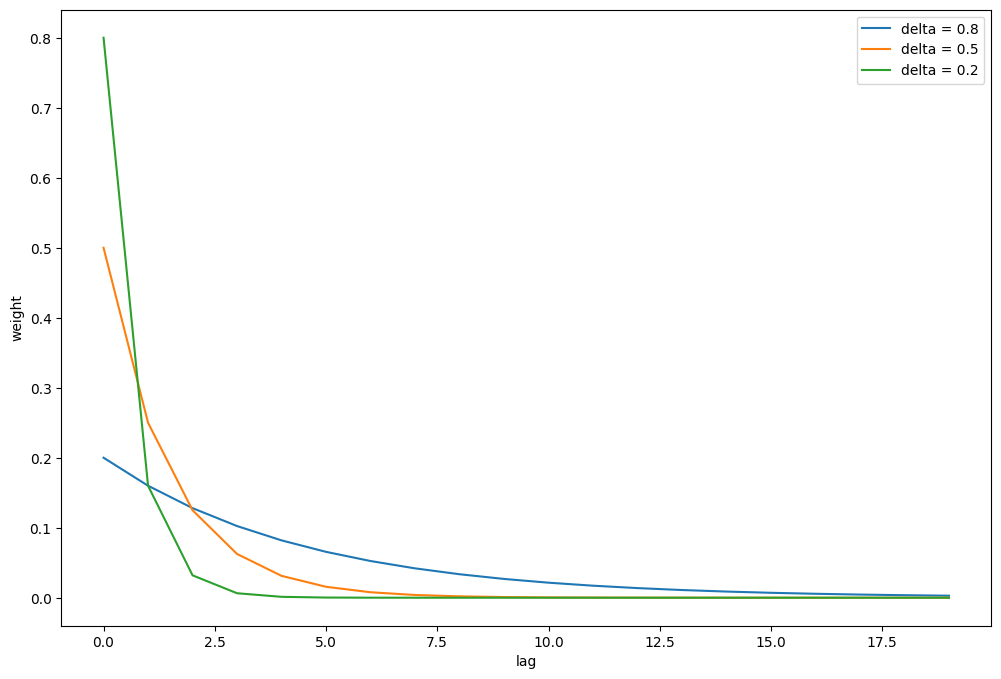

In [19]:
plot_weight([0.8, 0.5, 0.2])

横轴表示滞后月数（例如t-3相对于t，滞后3月），纵轴表示该月的权重  
从权重来看， delta越大，越能捕捉长期趋势；delta越小，对短期反应约敏感  
我希望捕捉相对长期、稳定的时序动量趋势，对短期扰动不那么敏感，选择delta = 0.8

In [20]:
rm_ewma_1 = rm1.apply(lambda column: ewma(column, 0.8))
rm_ewma_1

stkcd,000001.SZ,000006.SZ,000011.SZ,000012.SZ,000014.SZ,000019.SZ,000021.SZ,000025.SZ,000026.SZ,000027.SZ,...,688800.SH,688819.SH,830832.BJ,831726.BJ,832000.BJ,832566.BJ,832885.BJ,834599.BJ,835640.BJ,839167.BJ
202109,0.000560,-0.005623,-0.003566,-0.019965,-0.003337,0.001431,-0.025466,-0.009976,-0.014667,0.038883,...,-0.050620,-0.012149,0.071387,0.126571,0.131095,0.092121,0.073875,0.043563,0.014256,0.015448
202110,0.009675,-0.022403,-0.024364,-0.038368,-0.013731,-0.017048,-0.019279,-0.017990,-0.027926,-0.000779,...,-0.005939,-0.023793,0.053807,0.098675,0.071006,0.061547,0.003763,0.031342,-0.015507,-0.013048
202111,-0.012374,-0.020803,-0.021725,-0.013660,-0.004090,-0.012109,-0.005647,-0.006966,-0.010276,0.001128,...,0.089687,0.005777,0.033232,0.078874,0.042274,0.045264,0.039724,0.033989,-0.000658,0.014521
202112,-0.023051,-0.002224,0.000925,-0.009715,0.016718,-0.003446,-0.001697,-0.006108,-0.009044,0.000420,...,0.085288,-0.015358,0.021817,0.099403,0.051639,0.048850,0.010512,0.033466,-0.010190,-0.004415
202201,-0.028405,-0.012386,-0.014315,-0.028382,0.012159,-0.015163,-0.036570,-0.014886,-0.032168,-0.028756,...,0.036813,-0.037895,0.021505,0.046865,0.017859,0.017969,-0.005301,0.012873,-0.029832,-0.029718
202202,-0.030534,-0.012182,-0.016302,-0.037012,0.021188,0.013853,-0.027626,-0.016261,-0.029871,-0.020207,...,0.034651,-0.039343,-0.006606,0.025192,-0.012647,0.002767,-0.024628,-0.012196,-0.034236,-0.044317
202203,-0.031211,0.025420,0.024728,-0.055424,0.095649,0.029799,-0.055341,-0.006737,-0.047182,-0.037790,...,0.032685,-0.056842,-0.014383,-0.011807,-0.033275,-0.011916,-0.048717,-0.032246,-0.056314,-0.069169
202204,-0.030430,-0.018777,-0.012354,-0.092238,0.051817,-0.001571,-0.071547,-0.055303,-0.054599,-0.049703,...,0.004697,-0.086608,-0.074364,-0.033854,-0.063862,-0.009189,-0.072843,-0.024112,-0.065785,-0.136196
202205,-0.039487,-0.008483,0.007648,-0.058570,0.053612,0.044655,-0.034266,0.105224,-0.009055,-0.027690,...,0.001310,-0.035977,-0.051157,0.008240,-0.049092,-0.003246,-0.046656,-0.012500,-0.038733,-0.026575
202206,-0.018806,0.006530,0.011303,0.000914,0.029970,0.016933,-0.014871,0.101584,-0.005005,-0.013534,...,0.038254,-0.012348,-0.028335,0.008456,-0.035001,-0.005125,-0.013811,-0.016749,-0.030478,0.015064


In [21]:
rm_excess_1 = rm1 - rm_ewma_1
rm_excess_1

stkcd,000001.SZ,000006.SZ,000011.SZ,000012.SZ,000014.SZ,000019.SZ,000021.SZ,000025.SZ,000026.SZ,000027.SZ,...,688800.SH,688819.SH,830832.BJ,831726.BJ,832000.BJ,832566.BJ,832885.BJ,834599.BJ,835640.BJ,839167.BJ
month,,,,,,,,,,,,,,,,,,,,,
202109,0.002239,-0.022493,-0.014265,-0.079859,-0.013347,0.005726,-0.101863,-0.039903,-0.058669,0.155531,...,-0.202479,-0.048597,0.285548,0.506284,0.524378,0.368485,0.295499,0.174252,0.057022,0.061790
202110,0.036461,-0.067118,-0.083190,-0.073614,-0.041577,-0.073920,0.024746,-0.032059,-0.053036,-0.158646,...,0.178724,-0.046575,-0.070319,-0.111585,-0.240355,-0.122297,-0.280447,-0.048886,-0.119049,-0.113983
202111,-0.088194,0.006397,0.010555,0.098833,0.038564,0.019756,0.054530,0.044098,0.070602,0.007629,...,0.382504,0.118279,-0.082300,-0.079203,-0.114927,-0.065132,0.143843,0.010590,0.059393,0.110276
202112,-0.042709,0.074319,0.090600,0.015782,0.083231,0.034653,0.015798,0.003432,0.004929,-0.002833,...,-0.017599,-0.084538,-0.045661,0.082116,0.037461,0.014343,-0.116847,-0.002092,-0.038127,-0.075745
202201,-0.021417,-0.040648,-0.060959,-0.074669,-0.018234,-0.046868,-0.139491,-0.035114,-0.092496,-0.116705,...,-0.193901,-0.090149,-0.001250,-0.210153,-0.135123,-0.123524,-0.063251,-0.082373,-0.078569,-0.101209
202202,-0.008514,0.000815,-0.007951,-0.034520,0.036115,0.116062,0.035777,-0.005500,0.009188,0.034196,...,-0.008647,-0.005791,-0.112442,-0.086693,-0.122021,-0.060805,-0.077309,-0.100276,-0.017616,-0.058396
202203,-0.002710,0.150408,0.164121,-0.073649,0.297845,0.063784,-0.110859,0.038098,-0.069243,-0.070330,...,-0.007862,-0.069994,-0.031109,-0.147993,-0.082514,-0.058736,-0.096353,-0.080202,-0.088309,-0.099407
202204,0.003126,-0.176790,-0.148328,-0.147257,-0.175328,-0.125480,-0.064825,-0.194264,-0.029670,-0.047654,...,-0.111954,-0.119066,-0.239922,-0.088190,-0.122345,0.010909,-0.096507,0.032536,-0.037887,-0.268109
202205,-0.036231,0.041175,0.080010,0.134672,0.007177,0.184905,0.149124,0.642107,0.182175,0.088054,...,-0.013549,0.202522,0.092824,0.168377,0.059078,0.023775,0.104748,0.046451,0.108211,0.438484


事前波动率的估计，也采用指数加权平均，但是相对于当期滞后一期

In [22]:
ex_vola = (rm_excess_1 ** 2).apply(lambda column: ewma(column, 0.8)).shift(1)
ex_vola 

stkcd,000001.SZ,000006.SZ,000011.SZ,000012.SZ,000014.SZ,000019.SZ,000021.SZ,000025.SZ,000026.SZ,000027.SZ,...,688800.SH,688819.SH,830832.BJ,831726.BJ,832000.BJ,832566.BJ,832885.BJ,834599.BJ,835640.BJ,839167.BJ
202109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
202110,0.000001,0.000101,0.000041,0.001275,0.000036,0.000007,0.002075,0.000318,0.000688,0.004838,...,0.008200,0.000472,0.016308,0.051265,0.054994,0.027156,0.017464,0.006073,0.000650,0.000764
202111,0.000267,0.000982,0.001417,0.002104,0.000374,0.001098,0.001783,0.000460,0.001113,0.008904,...,0.012948,0.000812,0.014035,0.043502,0.055550,0.024716,0.029701,0.005336,0.003355,0.003209
202112,0.001769,0.000794,0.001156,0.003637,0.000597,0.000957,0.002021,0.000757,0.001888,0.007135,...,0.039620,0.003447,0.012583,0.036056,0.047081,0.020621,0.027899,0.004291,0.003389,0.005000
202201,0.001780,0.001740,0.002566,0.002959,0.001863,0.001005,0.001667,0.000608,0.001515,0.005710,...,0.031758,0.004187,0.010483,0.030194,0.037946,0.016538,0.025050,0.003434,0.003002,0.005147
202202,0.001516,0.001722,0.002796,0.003483,0.001557,0.001244,0.005225,0.000733,0.002923,0.007292,...,0.032926,0.004975,0.008387,0.032988,0.034008,0.016282,0.020840,0.004104,0.003636,0.006166
202203,0.001227,0.001378,0.002250,0.003024,0.001506,0.003689,0.004436,0.000593,0.002355,0.006067,...,0.026356,0.003987,0.009238,0.027893,0.030184,0.013765,0.017867,0.005294,0.002971,0.005615
202204,0.000983,0.005627,0.007187,0.003504,0.018947,0.003765,0.006007,0.000764,0.002843,0.005843,...,0.021097,0.004169,0.007584,0.026695,0.025509,0.011702,0.016151,0.005522,0.003937,0.006468
202205,0.000788,0.010752,0.010150,0.007140,0.021306,0.006161,0.005646,0.008159,0.002451,0.005129,...,0.019384,0.006171,0.017580,0.022912,0.023401,0.009386,0.014783,0.004629,0.003436,0.019551
202206,0.000893,0.008941,0.009400,0.009340,0.017055,0.011767,0.008964,0.088988,0.008598,0.005654,...,0.015544,0.013140,0.015787,0.023999,0.019419,0.007622,0.014021,0.004135,0.005091,0.054095


In [23]:
def TSMOM(rm: pd.DataFrame, delta: float) -> pd.DataFrame:
    """
    计算时间序列动量
    集成了前面指数加权收益率、事前波动率的计算
    前面的过程作为检查
    """
    def _ewma(ser:pd.Series, delta:float) -> pd.Series:
        ser_ewma = pd.Series(dtype=float)
        for i in range(len(rm)):
            idx = ser.index[i]
            if i == 0:
                ser_ewma.loc[idx] = ((1 - delta) * ser.iloc[i]) 
            else:
                 ser_ewma.loc[idx] = (delta * ser_ewma.iloc[i-1] + (1 - delta) * ser.iloc[i]) 
        return ser_ewma
    
    rm_ewma = rm.apply(lambda column: _ewma(column, delta))
    rm_excess = rm - rm_ewma
    ex_vola = (rm_excess ** 2).apply(lambda column: _ewma(column, delta)).shift(1)
    
    tsmom = np.sign(rm_excess.rolling(12, closed='left').mean()) * rm_excess / ex_vola
    return tsmom
    

采用指数加权移动平均，需要保证有连续的收益率序列，其中不含nan值  
数据集2存在nan值，可能原因是公司停牌、或者未上市  
<br>
若是公司停牌，简单将nan值替换为0并不合理，原因如下： 
时序动量因子背后的逻辑，是市场参与者对新信息反应不足，因此股价变动具有趋势性；而如果停牌期间，股价的nan值替换为0，意味着我们假设没有新信息进入市场、股票价格不发生变动；但事实上，停牌期间，仍有公司相关的信息进入市场，并在公司复牌后集中反映在股价上。因此，将nan值替换为0不合理。  

若是公司未上市，则可能会导致公司有效样本量太少（数据集只有两年，且需要预留一年作为滚动窗口计算因子值）  
<br>
因此，综合考虑下，我仅采用数据集1，计算时序动量因子

In [30]:
tsmom = TSMOM(rm1, 0.8)
tsmom = tsmom.dropna()
tsmom

stkcd,000001.SZ,000006.SZ,000011.SZ,000012.SZ,000014.SZ,000019.SZ,000021.SZ,000025.SZ,000026.SZ,000027.SZ,...,688800.SH,688819.SH,830832.BJ,831726.BJ,832000.BJ,832566.BJ,832885.BJ,834599.BJ,835640.BJ,839167.BJ
month,,,,,,,,,,,,,,,,,,,,,
202209,7.910805,4.504988,8.777514,-4.569715,-7.349432,-16.401112,18.867720,-1.206867,15.804352,21.947086,...,-8.642042,-6.538497,-11.149596,-0.327986,-1.609801,-6.711325,3.942399,19.130878,-9.933208,-5.501541
202210,18.263821,16.875526,-5.970834,1.141805,4.654083,-1.788893,-18.460744,-0.254371,-14.570334,-11.233319,...,-7.079469,-15.492619,-2.389226,0.339129,-10.529516,1.994667,-1.144399,-35.286708,-12.954928,-0.754756
202211,-78.188079,-92.031313,-29.879575,1.468119,-39.890086,10.364602,-0.073284,5.775862,18.470653,-14.985666,...,-1.147273,-3.844321,-10.581828,-8.577330,-3.258153,-17.943668,-3.618646,0.414348,24.752276,-7.539302
202212,-0.110843,-1.628506,-3.837378,-9.032114,-3.523247,-5.843524,-11.331637,-4.590779,-14.051378,-9.654479,...,5.833993,-2.468569,7.499034,5.672648,9.381721,10.418481,9.974420,-9.226713,-9.500780,-2.961764
202301,7.228944,-2.704956,-0.045219,-11.271556,0.331245,6.089781,-9.319827,2.401900,17.887018,-0.027845,...,0.598169,1.910115,-2.423188,-9.780493,-14.199435,-21.705529,-36.219906,-8.848603,40.256639,6.001733
202302,-8.289072,-0.200196,0.949235,-6.444123,-3.811963,8.685605,7.469105,-2.294405,-14.337534,-1.187974,...,12.837644,-3.498452,13.967124,4.211003,5.639185,5.672932,-8.147573,1.103815,-14.734978,-4.871348
202303,-12.945871,-4.215750,-18.588619,-4.853853,4.669598,-14.067994,44.733194,-1.634026,-4.903591,-11.369134,...,14.107132,-5.135226,-15.234587,7.778228,-6.900488,13.745337,-2.389964,-6.069823,-30.986177,-7.576709
202304,0.951320,1.762435,3.004708,-3.008421,-1.524655,5.385583,-5.280691,-2.445388,9.279023,24.903573,...,3.454491,-3.199354,10.400654,-3.668450,6.193067,-8.875620,0.075498,29.407417,5.242531,1.667820
202305,-9.111789,-1.458414,2.135577,-11.537206,1.311877,6.196110,19.571690,-0.067664,1.926914,27.162992,...,-14.410793,5.028468,4.888344,11.484898,9.827720,-27.293223,15.904004,5.194329,8.597738,-0.092072


# FF3MOM
参考：
https://zhuanlan.zhihu.com/p/95259084  
Fama E F, French K R. The cross‐section of expected stock returns[J]. the Journal of Finance, 1992, 47(2): 427-465.  
Blitz, D., J. Huij, and M. Martens (2011). Residual momentum. Journal of Empirical Finance, Vol. 18(3), 506 – 521.

计算FF3残差，在每个横截面上需要往前滚动36个月的数据；  
而网盘的数据仅有两年，没有足够的滚动窗口  
因此，我自行收集了2018.09-2023.09共5年的月度数据，  
<br>
数据来源：  
市值、账面市值比、PE： CSMAR  
股价：AKshare东方财富历史行情接口  
无风险利率：AKshare东方财富-拆借利率一览接口；采用中国银行同业拆借市场-1月利率 作为月度化无风险利率

代办：
1.确认三因子算法  
https://zhuanlan.zhihu.com/p/374959531  
2.获取数据  
需要市值、账面市值比或市盈率倒数、市场收益率、无风险收益率、月度收益率数据  
3.计算因子


### 下载、处理数据

股票月度回报率数据

In [2]:
#自定义的类，用于保存skshare东财历史行情接口的月度数据，详情可见utils.py
from utils import StockSaver
saver = StockSaver(root_path=os.getcwd())
saver.save_trade_data('20180101', '20231231',  'monthly', adjust='hfq')

Processing 300799: 100%|██████████████████████████████████████████████████| 5591/5591 [07:36<00:00, 12.24it/s]

下列股票日度数据请求失败，请重试：


[]

In [82]:
#批量处理保存在本地的月度历史行情数据，并生成月度回报率
storage_path = os.path.join(os.getcwd(), 'data', 'stock', 'trade', 'monthly')
files = os.listdir(storage_path)
iters = tqdm(files)
rm = pd.DataFrame(columns=['date', 'return'])
for file in iters:
    file_path = os.path.join(storage_path, file)
    stkcd = file.split("_")[0]
    
    #读取数据
    try:
        file_df = pd.read_csv(file_path, encoding='gbk')
    except:
        #该股票数据为空
        continue
    
    #剔除交易异常的股票
    file_df.rename(columns=fields, inplace=True)
    if (file_df['close'] <= 0).any():
        print(f"股票{stkcd}交易异常")
        continue
    
    #计算月度收益率
    file_df['return'] = file_df['close'].pct_change()
    file_df = file_df[['date', 'return']]
    file_df = file_df.dropna()
    file_df['stkcd'] = stkcd
    file_df['month'] = file_df['date'].apply(lambda x: x[:7].replace('-', ''))
    
    rm = pd.concat([rm, file_df], ignore_index=True)
    
    iters.set_description("Processing %s" % file)
rm.head()


Processing 000520_20180101_20231231.csv:   2%|▋                            | 125/5591 [00:01<00:59, 91.95it/s]

股票000502交易异常


Processing 000625_20180101_20231231.csv:   4%|█▏                           | 222/5591 [00:02<00:54, 99.00it/s]

股票000606交易异常


Processing 000712_20180101_20231231.csv:   5%|█▍                           | 284/5591 [00:03<00:55, 94.89it/s]

股票000693交易异常


Processing 000786_20180101_20231231.csv:   6%|█▋                           | 336/5591 [00:03<00:54, 96.19it/s]

股票000760交易异常


Processing 600076_20180101_20231231.csv:  55%|███████████████▎            | 3050/5591 [00:57<01:00, 42.07it/s]

股票600069交易异常


Processing 600100_20180101_20231231.csv:  55%|███████████████▍            | 3073/5591 [00:58<00:51, 48.85it/s]

股票600090交易异常
股票600091交易异常


Processing 600129_20180101_20231231.csv:  56%|███████████████▌            | 3105/5591 [00:58<01:01, 40.64it/s]

股票600122交易异常


Processing 600602_20180101_20231231.csv:  63%|█████████████████▌          | 3503/5591 [01:09<00:55, 37.84it/s]

股票600595交易异常


Processing 600640_20180101_20231231.csv:  63%|█████████████████▋          | 3540/5591 [01:10<00:47, 43.40it/s]

股票600634交易异常


Processing 600707_20180101_20231231.csv:  65%|██████████████████          | 3607/5591 [01:12<00:52, 37.60it/s]

股票600701交易异常


Processing 600739_20180101_20231231.csv:  65%|██████████████████▏         | 3640/5591 [01:13<00:57, 33.87it/s]

股票600734交易异常


Processing 600754_20180101_20231231.csv:  65%|██████████████████▎         | 3658/5591 [01:14<00:51, 37.43it/s]

股票600747交易异常


Processing 600774_20180101_20231231.csv:  66%|██████████████████▍         | 3677/5591 [01:14<00:46, 41.34it/s]

股票600767交易异常


Processing 600877_20180101_20231231.csv:  68%|██████████████████▉         | 3780/5591 [01:17<00:48, 37.07it/s]

股票600870交易异常


Processing 601992_20180101_20231231.csv:  73%|████████████████████▍       | 4087/5591 [01:27<00:47, 31.35it/s]

股票601975交易异常


Processing 873833_20180101_20231231.csv: 100%|████████████████████████████| 5591/5591 [02:24<00:00, 38.77it/s]


,date,return,stkcd,month
0,2018-02-28,-0.138792,000001,201802
1,2018-03-30,-0.092670,000001,201803
2,2018-04-27,-0.004437,000001,201804
3,2018-05-31,-0.059772,000001,201805
4,2018-06-29,-0.103414,000001,201806


In [83]:
rm['return'].describe()

count    305116.000000
mean          0.007065
std           0.144509
min          -0.918020
25%          -0.067528
50%          -0.006777
75%           0.059783
max           7.721842
Name: return, dtype: float64

财报数据

In [84]:
def read_csmarstyle_excel(path:str):
    file = pd.read_excel(path)
    file.rename(columns=fields, inplace=True)
    file = file.drop([0,1])
    file.reset_index(drop=True, inplace=True)
    return file
    

In [85]:
conmpany_info = read_csmarstyle_excel("./data/相对价值指标/FI_T10.xlsx")
conmpany_info.sort_values(by=['stkcd', 'Accper'])
conmpany_info.head()


C:\ProgramData\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,stkcd,ShortName,Accper,Indcd,Indnme,PE_1,PE_2,PE_TTM,MkV_A,MKV_B,BM_A,BM_B
0,000001,平安银行,2018-03-31,J66,货币金融服务,8.070766,7.094503,7.940305,3302871164999.50293,3302338483889.399902,1.010809,1.010972
1,000001,平安银行,2018-06-30,J66,货币金融服务,6.730575,5.8359,6.501241,3295337730092.137207,3295337039316.939941,1.021868,1.021868
2,000001,平安银行,2018-09-30,J66,货币金融服务,8.181832,6.956217,7.74655,3306558481730.898438,3306558045594.299805,1.01376,1.01376
3,000001,平安银行,2018-12-31,J66,货币金融服务,6.489427,6.489427,6.489427,3339609215737.516113,3339608458613.080078,1.02365,1.023651
4,000001,平安银行,2019-03-31,J66,货币金融服务,8.869345,7.390525,8.575301,3499366969084.065918,3499366673712.120117,1.008805,1.008805


财报数据月度化
4、5、6月的可用财报信息，来自于同年3月31日发布的财报，以此类推


In [86]:
def accper_to_month(accper:str) -> List[str]:
    year, month = accper.split('-')[:2]
    if month == '12':
        year = str(int(year) + 1)
        month = '0'
    months = [year + str(int(month) + i).zfill(2) for i in range(1,4)]
    return months


In [87]:
#把原本季度的每行，都复制成3行
data = list(conmpany_info.values)
monthly_info = pd.DataFrame(columns=conmpany_info.columns,data=data*3)
monthly_info.sort_values(by=['stkcd', 'Accper'], inplace=True)

#生成季度对应的月份
months = []
def _func(accper:pd.Series) -> None:
    global months
    months +=  accper_to_month(accper)
conmpany_info['Accper'].apply(_func)

#将月份赋值给dataframe
monthly_info['month'] = months
monthly_info.head(20)

,stkcd,ShortName,Accper,Indcd,Indnme,PE_1,PE_2,PE_TTM,MkV_A,MKV_B,BM_A,BM_B,month
0,000001,平安银行,2018-03-31,J66,货币金融服务,8.070766,7.094503,7.940305,3.302871e+12,3.302338e+12,1.010809,1.010972,201804
97654,000001,平安银行,2018-03-31,J66,货币金融服务,8.070766,7.094503,7.940305,3.302871e+12,3.302338e+12,1.010809,1.010972,201805
195308,000001,平安银行,2018-03-31,J66,货币金融服务,8.070766,7.094503,7.940305,3.302871e+12,3.302338e+12,1.010809,1.010972,201806
1,000001,平安银行,2018-06-30,J66,货币金融服务,6.730575,5.835900,6.501241,3.295338e+12,3.295337e+12,1.021868,1.021868,201807
97655,000001,平安银行,2018-06-30,J66,货币金融服务,6.730575,5.835900,6.501241,3.295338e+12,3.295337e+12,1.021868,1.021868,201808
195309,000001,平安银行,2018-06-30,J66,货币金融服务,6.730575,5.835900,6.501241,3.295338e+12,3.295337e+12,1.021868,1.021868,201809
2,000001,平安银行,2018-09-30,J66,货币金融服务,8.181832,6.956217,7.746550,3.306558e+12,3.306558e+12,1.013760,1.013760,201810
97656,000001,平安银行,2018-09-30,J66,货币金融服务,8.181832,6.956217,7.746550,3.306558e+12,3.306558e+12,1.013760,1.013760,201811
195310,000001,平安银行,2018-09-30,J66,货币金融服务,8.181832,6.956217,7.746550,3.306558e+12,3.306558e+12,1.013760,1.013760,201812
3,000001,平安银行,2018-12-31,J66,货币金融服务,6.489427,6.489427,6.489427,3.339609e+12,3.339608e+12,1.023650,1.023651,201901


无风险利率数据

In [88]:
rf = ak.rate_interbank('中国银行同业拆借市场', 'Chibor人民币', '1月')
rf.rename(columns=fields, inplace=True)

#保留2018-2023年的数据
rf = rf[ rf['date'].apply(lambda date: int(date.strftime("%Y"))).isin(range(2018, 2023+1))]

#按月份去重
#因为股票月度收益率的数据，是月末价/上月末价 - 1；所以无风险利率同样采取月末值
rf['month'] = rf['date'].apply(lambda date: date.strftime("%Y%m"))
rf.drop_duplicates(subset='month', keep='last', ignore_index=True, inplace=True)

#化为小数
rf['interest'] = rf['interest']/100

#月度化
rf['interest'] = (1 + rf['interest']) ** (1/12) - 1

rf = rf[['month', 'interest']]

rf

,month,interest
0,201801,0.003537
1,201802,0.003334
2,201803,0.003460
3,201804,0.003434
4,201805,0.003189
...,...,...
67,202308,0.001939
68,202309,0.002332
69,202310,0.002228
70,202311,0.002455


In [89]:
rf.describe()

,interest
count,72.000000
mean,0.002640
std,0.000625
min,0.001590
25%,0.002079
50%,0.002603
75%,0.003126
max,0.004158


市场回报率数据
计算方法：市值加权平均

In [90]:
market_return = rm[['month', 'stkcd', 'return']]
market_return = pd.merge(market_return, monthly_info[['month', 'stkcd', 'MkV_A']], how='left', on=['stkcd', 'month'])
market_return = market_return[market_return['month'].apply(int) > 201803]

#将缺失的市值，用该公司上一个月的市值填充
market_return['MkV_A'] = market_return.groupby('stkcd')['MkV_A'].transform(lambda x: x.fillna(method='ffill'))
market_return

#剔除缺失值
market_return.dropna(inplace=True)

#计算权重
market_return.sort_values(by=['month', 'stkcd'], inplace=True, ignore_index=True)
market_return['total_value'] = market_return.groupby('month')['MkV_A'].transform(sum)
market_return['weight'] =  market_return['MkV_A']/market_return['total_value']

#计算市场利率
market_return['temp'] = market_return['return'] * market_return['weight']
market_return['weighted_return'] = market_return.groupby('month')['temp'].transform(sum)  #市值加权
market_return['avg_return'] = market_return.groupby('month')['return'].transform(lambda x: x.mean())  #等权

market_return = market_return[['month', 'weighted_return', 'avg_return']]
market_return.drop_duplicates(inplace=True, ignore_index=True)

market_return

,month,weighted_return,avg_return
0,201804,-0.022993,-0.037738
1,201805,-0.016548,-0.005529
2,201806,-0.058215,-0.103748
3,201807,0.042725,-0.000211
4,201808,-0.024418,-0.079298
...,...,...,...
64,202308,-0.040036,-0.037133
65,202309,0.007320,-0.001074
66,202310,-0.019070,-0.009958
67,202311,-0.005137,0.050690


In [91]:
market_return.describe()

,weighted_return,avg_return
count,69.000000,69.000000
mean,0.001554,0.005588
std,0.031242,0.058806
min,-0.058215,-0.147366
25%,-0.024418,-0.029059
50%,-0.002046,-0.000029
75%,0.022285,0.032491
max,0.087149,0.217933


### 计算三因子

In [92]:
RMRF = pd.merge(market_return, rf, how='left', on='month')
RMRF['RMRF_mvw'] = RMRF['weighted_return'] - RMRF['interest']
RMRF['RMRF_eqw'] =  RMRF['avg_return'] - RMRF['interest']
RMRF = RMRF[['month', 'RMRF_mvw', 'RMRF_eqw']]
RMRF.describe()

,RMRF_mvw,RMRF_eqw
count,69.000000,69.000000
mean,-0.001051,0.002983
std,0.031322,0.058959
min,-0.061582,-0.149408
25%,-0.027087,-0.031038
50%,-0.005849,-0.002577
75%,0.020331,0.030429
max,0.085218,0.216002


In [93]:
data = rm[['month', 'stkcd', 'return']]
data = (pd.merge(data, monthly_info[['month', 'stkcd', 'MkV_A', 'BM_A']], 
                          how='left', on=['stkcd', 'month']))
data = data[data['month'].apply(int) > 201803]

#将缺失的值，用该公司上一个月的值填充
for col in ['MkV_A', 'BM_A']:
    data[col] = data.groupby('stkcd')[col].transform(lambda x: x.fillna(method='ffill'))
    
#剔除缺失值
data.dropna(inplace=True)

#交易日分组；在每个交易日，计算截面得因子值
def calcu_SMB_HML(month_df:pd.DataFrame) -> pd.DataFrame:
    month = month_df['month'].iloc[0]
    
    #按市值、账面市值进行2*3分组
    month_df['MV_group'] = pd.qcut(month_df['MkV_A'], 2, labels=['small', 'big'])
    month_df['BM_group'] = pd.qcut(month_df['BM_A'], 3, labels=['low','medium', 'high'])
    month_df['group'] = month_df.apply(lambda row: row['MV_group'] + row['BM_group'],
                                      axis=1)
    
    #每组收益率按组内市值加权
    month_df['total_value'] = month_df.groupby('group')['MkV_A'].transform(sum)
    month_df['weight'] = month_df['MkV_A'] / month_df['total_value']
    month_df['mv_wei_return'] = month_df['weight'] * month_df['return']
    group_return = month_df.groupby('group')['mv_wei_return'].sum()
    
    #计算SMB、HML
    SMB = ((group_return['smalllow'] + group_return['smallmedium'] + group_return['smallhigh']) / 3
          - (group_return['biglow'] + group_return['bigmedium'] + group_return['bighigh']) / 3 )
    
    HML = ((group_return['smallhigh'] + group_return['bighigh']) / 2
          - (group_return['smalllow'] + group_return['biglow']) / 2)
    
    return pd.DataFrame({'month': month,'SMB': [SMB], 'HML': [HML]})


SMB_HML = data.groupby('month').apply(calcu_SMB_HML)
SMB_HML.reset_index(drop=True, inplace=True)
SMB_HML

,month,SMB,HML
0,201804,-0.006014,0.011648
1,201805,-0.010456,-0.013793
2,201806,-0.035676,0.006113
3,201807,-0.005466,0.057970
4,201808,-0.021073,0.035386
...,...,...,...
64,202308,0.022336,0.003376
65,202309,0.012496,0.018957
66,202310,0.017633,-0.002010
67,202311,0.060668,-0.000695


In [94]:
SMB_HML.describe()

,SMB,HML
count,69.000000,69.000000
mean,0.005407,0.003012
std,0.039875,0.037839
min,-0.099171,-0.080505
25%,-0.021059,-0.021756
50%,0.000675,0.003376
75%,0.026485,0.028907
max,0.119860,0.090773


### 滚动36个月，进行FF3model回归，计算模型系数与残差  
模型为 r<sub>i,t</sub> = α<sub>i</sub> + β<sub>1,i</sub> * RMRF<sub>i,t</sub> + β<sub>2,i</sub> * RMRF<sub>i,t</sub>

In [176]:
regress_data = pd.merge(rm[rm['month'].apply(int) > 201803], RMRF, 'left', on='month')
regress_data = pd.merge(regress_data, SMB_HML, 'left', on='month')
regress_data['constant'] = 1
regress_data

,date,return,stkcd,month,RMRF_mvw,RMRF_eqw,SMB,HML,constant
0,2018-04-27,-0.004437,000001,201804,-0.026428,-0.041172,-0.006014,0.011648,1
1,2018-05-31,-0.059772,000001,201805,-0.019738,-0.008718,-0.010456,-0.013793,1
2,2018-06-29,-0.103414,000001,201806,-0.061582,-0.107116,-0.035676,0.006113,1
3,2018-07-31,0.049308,000001,201807,0.040270,-0.002667,-0.005466,0.057970,1
4,2018-08-31,0.071606,000001,201808,-0.027087,-0.081967,-0.021073,0.035386,1
...,...,...,...,...,...,...,...,...,...
298445,2023-02-23,-0.010227,873833,202302,-0.006211,0.026359,0.041686,0.010020,1
298446,2023-03-09,-0.035591,873833,202303,0.003327,-0.013392,-0.002082,0.009823,1
298447,2023-06-29,-0.015476,873833,202306,-0.006147,0.017261,0.009625,-0.010322,1
298448,2023-11-30,0.795647,873833,202311,-0.007592,0.048235,0.060668,-0.000695,1


In [177]:
result_lst: List[pd.DataFrame] = []

month_lst = regress_data['month'].unique()
window:int = 36

iters = tqdm(range(window, len(month_lst)))
for i in iters:
    #获取滚动窗口
    curr_month = month_lst[i]
    window_st = month_lst[i - window]
    window_ed = month_lst[i - 1]
    sample = regress_data[regress_data['month'].apply(int).isin(range(int(window_st), int(window_ed) + 1))]
    
    #计算残差动量
    def FF3_residualmom(stkcd_df:pd.DataFrame) -> float:
        #剔除滚动窗口不足的数据
        if len(stkcd_df) < 36:
            return np.nan
        
        #用FF3model计算残差序列
        X = stkcd_df[['RMRF_mvw', 'SMB', 'HML', 'constant']]
        y = stkcd_df['return']
        
        model = sm.OLS(y, X).fit()
        residuals = model.resid
        residuals = residuals.iloc[-12:-1]
        
        #计算残差动量
        resi_mom = residuals.sum() / (residuals.std() * np.sqrt(10))
            #残差动量分母，和11个月的标准差少相比少了 (11 - 1)^0.5， 补齐
        return resi_mom
        

    result = sample.groupby('stkcd').apply(FF3_residualmom)
    result = result.reset_index()
    result.rename(columns={0: 'FF3MOM'}, inplace=True)
    result['month'] = curr_month
    result_lst.append(result)
    
FF3MOM = pd.concat([df for df in result_lst], ignore_index=True)
FF3MOM.dropna(inplace=True)
FF3MOM
    

100%|█████████████████████████████████████████████████████████████████████████| 33/33 [03:37<00:00,  6.59s/it]


,stkcd,FF3MOM,month
0,000001,0.013303,202104
1,000002,0.916742,202104
2,000004,-1.446232,202104
3,000005,-1.311266,202104
4,000006,0.121756,202104
...,...,...,...
164649,873665,NaN,202312
164650,873690,NaN,202312
164651,873693,NaN,202312
164652,873726,NaN,202312


# 有效性测试

In [370]:
import scipy.stats as st
class FactorToolsKit:
    """
    传入数据结构为：
    行：日期
    列：股票code
    值：对应的值
    """
    
    @staticmethod
    def remove_outlier(
        df: pd.DataFrame, 
        criterion: str, 
        remove_method: str = 'winsorize'
    ) -> pd.DataFrame: 
        """
        在横截面去除异常值
        criterion： '3sigma' 或 'precent'
            '3sigma'把超过均值正负3个标准差的数据，视为异常值
            'precent'把左右尾部各2.5%数据视为异常值
        remove_method： 'winsorize' 或 'drop'
            分别是缩尾与截尾
        """
        def _process(row: pd.Series) -> pd.Series:
            if criterion == '3sigma':
                mean = row.mean()
                std = row.std()
                lower_bound = mean - 3 * std
                upper_bound = mean + 3 * std
            elif criterion == 'precent':
                lower_bound = row.quantile(0.025)
                upper_bound = row.quantile(0.9775)
            else:
                raise ValueError("criterion的参数只能为 '3sigma' 或 'precent'")
            
            if remove_method == 'winsorize':
                return_row = row.apply(lambda x: x if x >= lower_bound else lower_bound)
                return_row = return_row.apply(lambda x: x if x <= upper_bound else upper_bound)
            elif remove_method == 'drop':
                return_row = row.apply(lambda x: x if ((x >= lower_bound) & (x <= upper_bound)) else np.nan)
            else:
                raise ValueError("remove_method的参数只能为 'winsorize' 或 'drop'")
            return return_row
        
        return_df = df.apply(_process, axis=1)
        return return_df
    
    @staticmethod
    def standardize(df: pd.DataFrame, method:str='zscore'):
        """
        在横截面标准化数据
        method: 'zscore'  或 'minmax'
        分别为z值标准化 或 min_max标准化
        """
        def _process(row: pd.Series) -> pd.Series:
            if method == 'zscore':
                mean = row.mean()
                std = row.std()
                return row.apply(lambda x: (x - mean)/ std)
                 
            elif method == 'minmax':
                _min = row.min()
                _max = row.max()
                spread = _max - _min
                return row.apply(lambda x: (x - _mim) / spread)
            
        return df.apply(_process, axis=1)
    

    @staticmethod
    def calcu_IC_series(factor_df:pd.DataFrame, next_return:pd.DataFrame) -> pd.DataFrame:
        """
        计算IC序列
        对于传入dataframe
        横轴为日期
        纵轴为证券代码
        """
        #初始化待返回的IC序列Dataframe
        IC_df = pd.DataFrame(columns=['rankIC', 'p_value'])
        
        #在每个时间横截面计算ic
        iters = tqdm(factor_df.iterrows())
        for idx, factor_row in iters:
            try:
                return_row = next_return.loc[idx]
            except:
                print(f"日期{idx}缺乏下期收益率数据")
                continue

            #剔除缺失值
            calcu_df = pd.DataFrame({'factor': factor_row, 'next_return': return_row})
            calcu_df = calcu_df.dropna()

            #计算rankIC
            IC, p = st.spearmanr(calcu_df['factor'], calcu_df['next_return'])
            IC_df.loc[idx] = [IC, p]

            iters.set_description("Processing %s" % idx)

        return IC_df
    
    @staticmethod
    def plot_ICseries(IC_df:pd.DataFrame, ma:int) -> None:
        plt.figure(figsize=(20, 12))
        IC_df['rankIC'].plot(color='lightblue', label='rankIC')
        IC_df['rankIC'].rolling(ma).mean().plot(color='purple', label=f'{ma} periods MA')
        plt.axhline(y=0, color='r', linestyle='--')
        plt.legend()
        plt.show()
    
    @staticmethod
    def report_IC_IR(IC_df:pd.DataFrame) -> pd.DataFrame:
        ic_mean = IC_df['rankIC'].mean()
        ic_std = IC_df['rankIC'].std()  
        #检验IC均值是否显著不为0
        t, p = st.ttest_1samp(IC_df['rankIC'].astype(float), 0)

        data = {
            'IC_mean': [ic_mean],
            'ICIR': [ic_mean / ic_std],
            #IR计算中，分母实际上是IC的标准差，而不是方差
            'IC_t_value': [t],
            'IC_p_value': [p]      
        }
        return pd.DataFrame(data)
    
    @staticmethod
    def grouped_backtest(group_return: pd.DataFrame, period:str) -> pd.DataFrame:
        (1 + group_return).cumprod().plot()
        plt.ylabel('cumulative return')
        plt.legend()
        plt.show()
        
        def performance(col):
            ann_ret = ep.annual_return(col, period=period)
            ann_vola = ep.annual_volatility(col, period=period)
            max_dd = ep.max_drawdown(col)
            sharpe = ep.sharpe_ratio(col, period=period)
            calmar = ep.calmar_ratio(col, period=period)

            data = {
                '年化复合收益率': ann_ret,
                '年化波动率': ann_vola,
                '最大回撤比列': max_dd,
                '夏普比率': sharpe,
                '卡玛比率': calmar
            }
            return pd.Series(data)
        
        return group_return.apply(performance).T
        
        
        


沪深300成分股  
akshare仅能获取当日沪深300指数的成分股  
以下回测，假定沪深300成分股不会随时间发生太大变化

In [203]:
index_info = ak.index_stock_cons_csindex()
hs300_lst = list(index_info['成分券代码'])

### 时序动量因子

全A股（不含缺失数据的股票）有效性测试

In [256]:
#去极值
tk = FactorToolsKit()
factor_df = tk.remove_outlier(tsmom, '3sigma')
factor_df

stkcd,000001.SZ,000006.SZ,000011.SZ,000012.SZ,000014.SZ,000019.SZ,000021.SZ,000025.SZ,000026.SZ,000027.SZ,...,688800.SH,688819.SH,830832.BJ,831726.BJ,832000.BJ,832566.BJ,832885.BJ,834599.BJ,835640.BJ,839167.BJ
month,,,,,,,,,,,,,,,,,,,,,
202209,7.910805,4.504988,8.777514,-4.569715,-7.349432,-16.401112,18.867720,-1.206867,15.804352,21.947086,...,-8.642042,-6.538497,-11.149596,-0.327986,-1.609801,-6.711325,3.942399,19.130878,-9.933208,-5.501541
202210,18.263821,16.875526,-5.970834,1.141805,4.654083,-1.788893,-18.460744,-0.254371,-14.570334,-11.233319,...,-7.079469,-15.492619,-2.389226,0.339129,-10.529516,1.994667,-1.144399,-35.286708,-12.954928,-0.754756
202211,-78.188079,-85.611385,-29.879575,1.468119,-39.890086,10.364602,-0.073284,5.775862,18.470653,-14.985666,...,-1.147273,-3.844321,-10.581828,-8.577330,-3.258153,-17.943668,-3.618646,0.414348,24.752276,-7.539302
202212,-0.110843,-1.628506,-3.837378,-9.032114,-3.523247,-5.843524,-11.331637,-4.590779,-14.051378,-9.654479,...,5.833993,-2.468569,7.499034,5.672648,9.381721,10.418481,9.974420,-9.226713,-9.500780,-2.961764
202301,7.228944,-2.704956,-0.045219,-11.271556,0.331245,6.089781,-9.319827,2.401900,17.887018,-0.027845,...,0.598169,1.910115,-2.423188,-9.780493,-14.199435,-21.705529,-36.219906,-8.848603,31.789385,6.001733
202302,-8.289072,-0.200196,0.949235,-6.444123,-3.811963,8.685605,7.469105,-2.294405,-14.337534,-1.187974,...,12.837644,-3.498452,13.967124,4.211003,5.639185,5.672932,-8.147573,1.103815,-14.734978,-4.871348
202303,-12.945871,-4.215750,-18.588619,-4.853853,4.669598,-14.067994,44.733194,-1.634026,-4.903591,-11.369134,...,14.107132,-5.135226,-15.234587,7.778228,-6.900488,13.745337,-2.389964,-6.069823,-30.986177,-7.576709
202304,0.951320,1.762435,3.004708,-3.008421,-1.524655,5.385583,-5.280691,-2.445388,9.279023,24.903573,...,3.454491,-3.199354,10.400654,-3.668450,6.193067,-8.875620,0.075498,29.407417,5.242531,1.667820
202305,-9.111789,-1.458414,2.135577,-11.537206,1.311877,6.196110,19.571690,-0.067664,1.926914,27.162992,...,-14.410793,5.028468,4.888344,11.484898,9.827720,-27.293223,15.904004,5.194329,8.597738,-0.092072


In [257]:
#市值中性化
factor_df = factor_df.reset_index().melt(id_vars='month', value_name='factor')
factor_df['stkcd'] = factor_df['stkcd'].apply(lambda x: x[:6])
mv_df = monthly_info[['month', 'stkcd', 'MkV_A']]
regress_df = pd.merge(factor_df, mv_df, 'left', on=['month', 'stkcd'])
regress_df['MkV_A'] = regress_df['MkV_A'].apply(np.log)
regress_df['constant'] = 1
X = regress_df[['MkV_A', 'constant']]
y = regress_df['factor']    
model = sm.OLS(y, X).fit()
residuals = model.resid
factor_df['factor'] = residuals
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 factor   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     10.85
Date:                Sun, 04 Feb 2024   Prob (F-statistic):           0.000989
Time:                        16:13:38   Log-Likelihood:            -1.2517e+05
No. Observations:               30336   AIC:                         2.503e+05
Df Residuals:                   30334   BIC:                         2.504e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
MkV_A         -0.1960      0.060     -3.294      0.0

In [258]:
"""
#行业中性化
industy_df = monthly_info[['month', 'stkcd', 'Indcd']]
dummies = pd.get_dummies(industy_df['Indcd'], prefix='Ind')
industy_df = industy_df[['month', 'stkcd']]
industy_df = pd.concat([industy_df, dummies], axis=1)
regress_df = pd.merge(factor_df, industy_df, 'left', on=['month', 'stkcd'])
regress_df['constant'] = 1
X = regress_df[[col for col in regress_df.columns if col.startswith('Ind')] + ['constant']]
y = regress_df['factor']  
model = sm.OLS(y, X).fit()
residuals = model.resid
factor_df['factor'] = residuals
print(model.summary())
"""

"\n#行业中性化\nindusty_df = monthly_info[['month', 'stkcd', 'Indcd']]\ndummies = pd.get_dummies(industy_df['Indcd'], prefix='Ind')\nindusty_df = industy_df[['month', 'stkcd']]\nindusty_df = pd.concat([industy_df, dummies], axis=1)\nregress_df = pd.merge(factor_df, industy_df, 'left', on=['month', 'stkcd'])\nregress_df['constant'] = 1\nX = regress_df[[col for col in regress_df.columns if col.startswith('Ind')] + ['constant']]\ny = regress_df['factor']  \nmodel = sm.OLS(y, X).fit()\nresiduals = model.resid\nfactor_df['factor'] = residuals\nprint(model.summary())\n"

In [259]:
factor_df

,month,stkcd,factor
0,202209,000001,10.837982
1,202210,000001,21.191475
2,202211,000001,-75.260426
3,202212,000001,2.816810
4,202301,000001,10.162114
...,...,...,...
30331,202304,839167,3.007717
30332,202305,839167,1.247825
30333,202306,839167,3.837803
30334,202307,839167,1.874942


In [260]:
#z值标准化
factor_df = factor_df.pivot(index='month', columns='stkcd', values='factor')
factor_df = tk.standardize(factor_df)
factor_df

stkcd,000001,000006,000011,000012,000014,000019,000021,000025,000026,000027,...,688800,688819,830832,831726,832000,832566,832885,834599,835640,839167
month,,,,,,,,,,,,,,,,,,,,,
202209,0.500203,0.196217,0.484532,-0.419098,-0.635659,-1.239529,1.180260,-0.203868,0.946612,1.405743,...,-0.720158,-0.550780,-0.910415,-0.179116,-0.267903,-0.608314,0.113229,1.174262,-0.812877,-0.520850
202210,1.316989,1.184898,-0.057379,0.334294,0.502524,0.163060,-0.726377,0.244197,-0.536506,-0.321330,...,-0.121596,-0.564340,0.108263,0.251905,-0.338515,0.345877,0.172780,-1.656696,-0.452007,0.199106
202211,-3.631303,-4.053383,-1.280954,0.286432,-1.794202,0.718201,0.211066,0.487752,1.115610,-0.519490,...,0.146582,0.024310,-0.345749,-0.249755,0.013875,-0.712435,-0.001568,0.218297,1.425747,-0.192090
202212,0.184786,-0.078740,-0.313618,-0.835051,-0.311372,-0.531255,-1.068187,-0.406468,-1.387064,-0.870607,...,0.671383,-0.156042,0.796289,0.600834,0.978813,1.096110,1.044844,-0.887257,-0.925660,-0.273293
202301,1.221911,0.228919,0.462724,-0.545307,0.471336,1.005649,-0.366330,0.668844,2.064126,0.497745,...,0.509354,0.651885,0.198983,-0.476355,-0.877746,-1.548530,-2.868491,-0.352804,3.316139,0.966560
202302,-0.861092,-0.122560,-0.010359,-0.774474,-0.538167,0.784896,0.684451,-0.367736,-1.636154,-0.195397,...,1.220573,-0.461894,1.296246,0.264448,0.412452,0.426206,-1.027082,-0.015497,-1.685562,-0.670096
202303,-0.757809,-0.196490,-1.250312,-0.241879,0.425324,-0.930751,3.376181,-0.026308,-0.270219,-0.696876,...,1.124730,-0.259435,-1.044722,0.626140,-0.445371,1.067391,-0.113966,-0.352205,-2.177786,-0.482424
202304,0.224534,0.210763,0.278328,-0.064083,0.000165,0.409322,-0.191053,-0.045616,0.628067,1.568204,...,0.295801,-0.070675,0.674832,-0.143918,0.425687,-0.440509,0.073520,1.795457,0.389364,0.173546
202305,-0.564410,-0.058701,0.210758,-0.828745,0.126520,0.512669,1.559356,0.030823,0.177022,2.156734,...,-1.067560,0.445627,0.379767,0.879034,0.750570,-2.083938,1.218388,0.430313,0.681118,0.003932


In [261]:
#计算 IC、 ICIR
next_return = rm1.shift(-1).iloc[:-1]
next_return.columns = next_return.columns.map(lambda x: x[:6])
ic = tk.calcu_IC_series(factor_df, next_return)
ic

Processing 202307: : 12it [00:00, 156.43it/s]

日期202308缺乏下期收益率数据


,rankIC,p_value
202209,-0.003836,8.471410e-01
202210,0.045065,2.345966e-02
202211,-0.153795,7.533803e-15
202212,0.064752,1.123928e-03
202301,-0.068687,5.484796e-04
202302,0.078731,7.409248e-05
202303,0.015800,4.271661e-01
202304,-0.163480,1.325286e-16
202305,0.117987,2.678594e-09
202306,-0.041165,3.849203e-02


In [262]:
tk.report_IC_IR(ic)

,IC_mean,ICIR,IC_t_value,IC_p_value
0,-0.010433,-0.115042,-0.381551,0.710776


沪深300成分股有效性测试

In [301]:
#保留沪深300成分股
target_columns = [stkcd for stkcd in tsmom.columns if stkcd[:6] in hs300_lst]
print(f"有效股票为{len(target_columns)}只")
factor_df = tsmom[target_columns] 
factor_df

有效股票为220只


stkcd,000001.SZ,000063.SZ,000100.SZ,000157.SZ,000333.SZ,000408.SZ,000538.SZ,000596.SZ,000617.SZ,000625.SZ,...,603986.SH,603993.SH,605117.SH,605499.SH,688036.SH,688111.SH,688303.SH,688363.SH,688396.SH,688599.SH
month,,,,,,,,,,,,,,,,,,,,,
202209,7.910805,27.185989,11.788611,8.212231,12.589230,-2.238563,-5.238917,4.229538,-21.736998,-2.068212,...,14.734132,2.021306,-0.996622,3.330060,5.449844,-17.091475,6.980672,-7.857885,6.891767,-4.252512
202210,18.263821,-21.049088,-19.056035,0.605743,21.596225,-1.139046,-15.950696,-25.175781,-3.307389,-0.745589,...,-2.204047,-6.472419,-12.186332,-13.997343,-19.150894,-108.268764,-9.559694,19.425490,-21.716756,0.809280
202211,-78.188079,17.463267,0.217720,-63.339152,-27.493542,-5.543983,7.159924,-9.170912,189.424475,-3.982036,...,-27.359727,-16.150488,-0.792441,0.172108,-21.698230,-5.043418,-2.326867,0.089691,3.522775,3.505210
202212,-0.110843,2.052887,-9.518853,-18.604428,-6.874835,-13.736605,-16.247858,-4.196250,-5.948011,-2.753962,...,-1.170997,-3.431319,5.070095,-0.765950,-0.684420,-1.557519,-11.445410,-26.752759,-2.739908,1.519952
202301,7.228944,2.293931,-29.313658,34.344188,-5.423947,-5.349968,-17.879298,1.693219,-0.006326,4.563273,...,-9.551104,37.207431,-0.710097,1.196064,-4.360230,-1.654601,-5.450359,-3.434363,2.893872,-3.213376
202302,-8.289072,46.104749,7.508812,47.512117,-5.927491,0.313270,-5.660358,-4.227297,-2.548708,-3.446607,...,-8.769491,-3.315480,2.645889,16.616934,-6.072216,-1.242572,-1.744684,-0.440561,-9.702151,6.580698
202303,-12.945871,-8.035745,-2.456809,-17.613551,-1.219825,14.045976,-19.707761,3.720356,4.655802,-4.277972,...,15.189804,-2.648491,11.112894,-12.937522,17.470643,28.511972,6.168800,-8.972729,22.535307,7.326068
202304,0.951320,8.807922,-21.821091,0.918217,5.878408,-0.742081,27.556674,-9.531462,-1.264673,0.776546,...,-14.938194,-0.549664,0.653767,-10.951951,-4.281266,-4.263812,-12.792186,-8.649454,-19.460396,2.655057
202305,-9.111789,0.968909,16.528624,-7.310275,-15.243526,-4.822332,-26.183213,-15.758185,-1.174956,1.030053,...,3.726956,-11.881263,1.830554,-8.594922,5.836150,-0.654317,-18.345158,4.189810,2.178943,10.308176


In [302]:
#去极值
factor_df = tk.remove_outlier(factor_df, '3sigma')

#市值中性化
factor_df = factor_df.reset_index().melt(id_vars='month', value_name='factor')
factor_df['stkcd'] = factor_df['stkcd'].apply(lambda x: x[:6])
mv_df = monthly_info[['month', 'stkcd', 'MkV_A']]
regress_df = pd.merge(factor_df, mv_df, 'left', on=['month', 'stkcd'])
regress_df['MkV_A'] = regress_df['MkV_A'].apply(np.log)
regress_df['constant'] = 1
X = regress_df[['MkV_A', 'constant']]
y = regress_df['factor']    
model = sm.OLS(y, X).fit()
residuals = model.resid
factor_df['factor'] = residuals
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                 factor   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.160
Date:                Sun, 04 Feb 2024   Prob (F-statistic):              0.142
Time:                        18:19:29   Log-Likelihood:                -12145.
No. Observations:                2640   AIC:                         2.429e+04
Df Residuals:                    2638   BIC:                         2.431e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
MkV_A          0.4435      0.302      1.470      0.1

In [303]:
#z值标准化
factor_df = factor_df.pivot(index='month', columns='stkcd', values='factor')
factor_df = tk.standardize(factor_df)
factor_df

stkcd,000001,000063,000100,000157,000333,000408,000538,000596,000617,000625,...,603986,603993,605117,605499,688036,688111,688303,688363,688396,688599
month,,,,,,,,,,,,,,,,,,,,,
202209,0.024344,1.270348,0.335552,0.140679,0.359841,-0.466995,-0.660199,-0.099341,-1.719495,-0.494567,...,0.542123,-0.246567,-0.374292,-0.106779,-0.006176,-1.362174,0.089566,-0.780387,0.089400,-0.616635
202210,0.576697,-0.563435,-0.506909,0.095382,0.704950,0.055780,-0.396574,-0.681286,-0.048564,0.048977,...,0.019480,-0.124389,-0.274602,-0.319895,-0.490040,-3.166576,-0.200533,0.685776,-0.560820,0.098359
202211,-1.345376,0.623299,0.271155,-1.010678,-0.298030,0.170457,0.423437,0.087184,3.518093,0.189571,...,-0.274995,-0.058080,0.268043,0.293789,-0.160136,0.179699,0.233606,0.292635,0.355804,0.343237
202212,0.032781,0.415704,-0.842504,-1.780964,-0.595069,-1.210752,-1.506307,-0.234913,-0.512292,-0.094878,...,0.126978,-0.172045,0.820680,0.225057,0.179412,0.095839,-0.975263,-2.570440,-0.019123,0.374762
202301,0.630072,0.367792,-1.966659,2.749122,-0.232387,-0.138992,-1.091633,0.342025,0.153889,0.542176,...,-0.464210,2.942802,0.209648,0.360717,-0.086391,0.097621,-0.157575,0.010517,0.467373,-0.024416
202302,-0.718627,3.338514,0.755084,3.365518,-0.433961,0.208752,-0.343624,-0.227442,-0.156451,-0.172927,...,-0.595189,-0.163257,0.418853,1.639099,-0.366919,0.032811,0.017727,0.153644,-0.657183,0.700374
202303,-0.689484,-0.438159,-0.219637,-0.808917,-0.182970,0.475727,-0.891638,0.042291,0.045421,-0.283766,...,0.512749,-0.219332,0.362288,-0.594222,0.601766,1.035392,0.154430,-0.440725,0.815301,0.183639
202304,-0.128242,0.233894,-0.977503,-0.064477,0.102456,-0.109906,0.988195,-0.479426,-0.185026,-0.078099,...,-0.681927,-0.131864,-0.049426,-0.504925,-0.264949,-0.278451,-0.594099,-0.415204,-0.861001,0.000179
202305,-0.293327,0.400181,1.339601,-0.083516,-0.609744,0.098554,-1.226492,-0.601621,0.236166,0.410979,...,0.598980,-0.376005,0.511301,-0.119254,0.722380,0.306040,-0.737475,0.656140,0.503643,0.981382


In [304]:
ic = tk.calcu_IC_series(factor_df, next_return)
ic

Processing 202308: : 12it [00:00, 97.82it/s]


,rankIC,p_value
202209,0.170912,0.011107
202210,0.123665,0.067125
202211,-0.166160,0.013599
202212,0.017340,0.798146
202301,0.122057,0.070786
202302,-0.082276,0.224189
202303,-0.018762,0.781989
202304,0.066701,0.324722
202305,0.102841,0.128331
202306,-0.016658,0.805923


In [305]:
tk.report_IC_IR(ic)

,IC_mean,ICIR,IC_t_value,IC_p_value
0,0.005199,0.043788,0.151688,0.88218


无论在哪个股票池中，时序动量因子的ic值均不显著异于0
在A股市场，时序动量似乎不是有效因子

### FF3残差动量

In [180]:
#矩阵化
rm = rm.pivot(index='month', columns='stkcd', values='return')
FF3MOM = FF3MOM.pivot(index='month', columns='stkcd', values='FF3MOM')

In [281]:
#去极值
factor_df = tk.remove_outlier(FF3MOM, '3sigma')

#市值中性化
factor_df = factor_df.reset_index().melt(id_vars='month', value_name='factor')
mv_df = monthly_info[['month', 'stkcd', 'MkV_A']]
regress_df = pd.merge(factor_df, mv_df, 'left', on=['month', 'stkcd'])
regress_df['MkV_A'] = regress_df['MkV_A'].apply(np.log)
regress_df['constant'] = 1

regress_df.isna().any()

month       False
stkcd       False
factor      False
MkV_A        True
constant    False
dtype: bool

In [282]:
regress_df.dropna(inplace=True)
X = regress_df[['MkV_A', 'constant']]
y = regress_df['factor']    
model = sm.OLS(y, X).fit()
residuals = model.resid
factor_df['factor'] = residuals
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                 factor   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     2034.
Date:                Sun, 04 Feb 2024   Prob (F-statistic):               0.00
Time:                        17:45:01   Log-Likelihood:            -2.2828e+05
No. Observations:              134055   AIC:                         4.566e+05
Df Residuals:                  134053   BIC:                         4.566e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
MkV_A          0.1190      0.003     45.097      0.0

In [283]:
#z值标准化
factor_df = factor_df.pivot(index='month', columns='stkcd', values='factor')
factor_df = tk.standardize(factor_df)
factor_df.head()

stkcd,000001,000002,000004,000005,000006,000007,000008,000009,000010,000011,...,836149,836263,836433,836675,837242,838030,838163,839167,839729,871396
month,,,,,,,,,,,,,,,,,,,,,
202104,-0.017704,0.705887,-0.423118,-0.357087,0.548035,1.150208,-1.548786,0.632079,0.362015,0.719057,...,-1.295002,-1.307347,-1.311750,-1.320730,-1.289737,-1.344288,-1.292966,-1.323957,-1.360118,-1.265831
202105,0.039577,0.018849,-0.339850,0.376446,0.578230,0.651219,-1.609742,0.285864,0.026968,0.858663,...,-1.372364,-1.383911,-1.388029,-1.396429,-1.367439,-1.418464,-1.370460,-1.399448,-1.433271,-1.345079
202106,0.194128,-0.050733,-0.523261,0.605025,0.600697,0.640775,-1.658255,0.512911,0.285138,0.629430,...,-1.426299,-1.437582,-1.441607,-1.449814,-1.421487,-1.471346,-1.424438,-1.452764,-1.485815,-1.399637
202107,0.362067,-0.248587,-0.512860,-0.021282,-0.075320,0.502242,-1.700584,0.048783,0.390929,0.206748,...,-1.491806,-1.492847,-1.499442,-1.510748,-1.474499,-1.522361,-1.475208,-1.510361,-1.555047,-1.454531
202108,0.654299,-0.389520,-0.136854,0.083769,-0.184137,0.621347,0.041829,0.894250,0.588049,-0.525965,...,-1.540360,-1.541399,-1.547982,-1.559266,-1.523086,-1.570858,-1.523793,-1.558881,-1.603482,-1.503155


In [285]:
#计算 IC、 ICIR
next_return = rm.shift(-1).iloc[:-1]
next_return.columns = next_return.columns.map(lambda x: x[:6])
ic = tk.calcu_IC_series(factor_df, next_return)
ic

Processing 202311: : 33it [00:00, 87.63it/s]

日期202312缺乏下期收益率数据


,rankIC,p_value
202104,-0.048753,1.816017e-03
202105,-0.013004,4.057187e-01
202106,0.074676,1.739644e-06
202107,0.182460,5.967957e-32
202108,-0.030551,5.074029e-02
202109,-0.005501,7.251147e-01
202110,-0.019529,2.118427e-01
202111,-0.011647,4.565459e-01
202112,-0.035325,2.390623e-02
202201,0.184556,1.265482e-32


In [286]:
tk.report_IC_IR(ic)

,IC_mean,ICIR,IC_t_value,IC_p_value
0,0.0199,0.238748,1.350561,0.186613


In [314]:
#保留沪深300成分股
target_columns = [stkcd for stkcd in FF3MOM.columns if stkcd in hs300_lst]
print(f"有效股票为{len(target_columns)}只")
factor_df = FF3MOM[target_columns] 

有效股票为281只


In [315]:
#去极值
factor_df = tk.remove_outlier(factor_df, '3sigma')

#市值中性化
factor_df = factor_df.reset_index().melt(id_vars='month', value_name='factor')
mv_df = monthly_info[['month', 'stkcd', 'MkV_A']]
regress_df = pd.merge(factor_df, mv_df, 'left', on=['month', 'stkcd'])
regress_df['MkV_A'] = regress_df['MkV_A'].apply(np.log)
regress_df['constant'] = 1

regress_df.isna().any()

month       False
stkcd       False
factor      False
MkV_A       False
constant    False
dtype: bool

In [316]:
X = regress_df[['MkV_A', 'constant']]
y = regress_df['factor']    
model = sm.OLS(y, X).fit()
residuals = model.resid
factor_df['factor'] = residuals
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 factor   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     284.7
Date:                Sun, 04 Feb 2024   Prob (F-statistic):           6.10e-63
Time:                        21:15:11   Log-Likelihood:                -15823.
No. Observations:                9273   AIC:                         3.165e+04
Df Residuals:                    9271   BIC:                         3.166e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
MkV_A          0.1612      0.010     16.873      0.0

In [317]:
#z值标准化
factor_df = factor_df.pivot(index='month', columns='stkcd', values='factor')
factor_df = tk.standardize(factor_df)
factor_df.head()

stkcd,000001,000002,000063,000069,000100,000157,000166,000301,000333,000338,...,688036,688065,688111,688126,688256,688363,688396,688561,688599,688981
month,,,,,,,,,,,,,,,,,,,,,
202104,0.009439,0.698328,-1.711842,0.630760,0.489264,1.046134,-0.011825,1.225092,0.894984,0.223691,...,-1.628131,-1.422188,-1.594402,-1.472687,-1.391894,-1.450535,-1.500529,-1.443199,-1.560095,-1.717920
202105,0.092931,0.096789,-1.758978,0.869051,0.689104,0.830224,0.072698,1.121880,0.665628,0.172998,...,-1.685066,-1.503229,-1.655285,-1.547816,-1.476480,-1.528257,-1.572400,-1.521780,-1.624993,-1.764345
202106,0.177872,-0.019035,-1.025661,1.084260,0.386019,0.609335,0.004264,0.986139,0.245454,0.020834,...,-1.700944,-1.517616,-1.670919,-1.562569,-1.490648,-1.542849,-1.587354,-1.536319,-1.640379,-1.780873
202107,0.353532,-0.152930,-1.724287,0.511021,0.086616,0.559091,-0.399738,1.009411,0.417196,0.048020,...,-1.748645,-1.585571,-1.737482,-1.669817,-1.547999,-1.642957,-1.679223,-1.597302,-1.723880,-1.829231
202108,0.597582,-0.319959,-1.605353,0.268986,0.215108,0.167370,-0.768809,1.215903,-0.100344,0.023769,...,-1.804799,-1.635318,-1.793197,-1.722874,-1.596270,-1.694958,-1.732649,-1.647510,-1.779061,-1.888551


In [318]:
#计算 IC、 ICIR
next_return = rm.shift(-1).iloc[:-1]
next_return.columns = next_return.columns.map(lambda x: x[:6])
ic = tk.calcu_IC_series(factor_df, next_return)
ic

Processing 202311: : 33it [00:00, 100.59it/s]

日期202312缺乏下期收益率数据


,rankIC,p_value
202104,0.008555,8.864708e-01
202105,-0.041560,4.877634e-01
202106,0.022071,7.125940e-01
202107,0.284029,1.298283e-06
202108,-0.103309,8.386539e-02
202109,0.073397,2.200016e-01
202110,-0.109723,6.626275e-02
202111,-0.054653,3.613755e-01
202112,-0.039749,5.069368e-01
202201,0.304918,1.855720e-07


In [319]:
tk.report_IC_IR(ic)

,IC_mean,ICIR,IC_t_value,IC_p_value
0,0.048792,0.366441,2.072901,0.046583


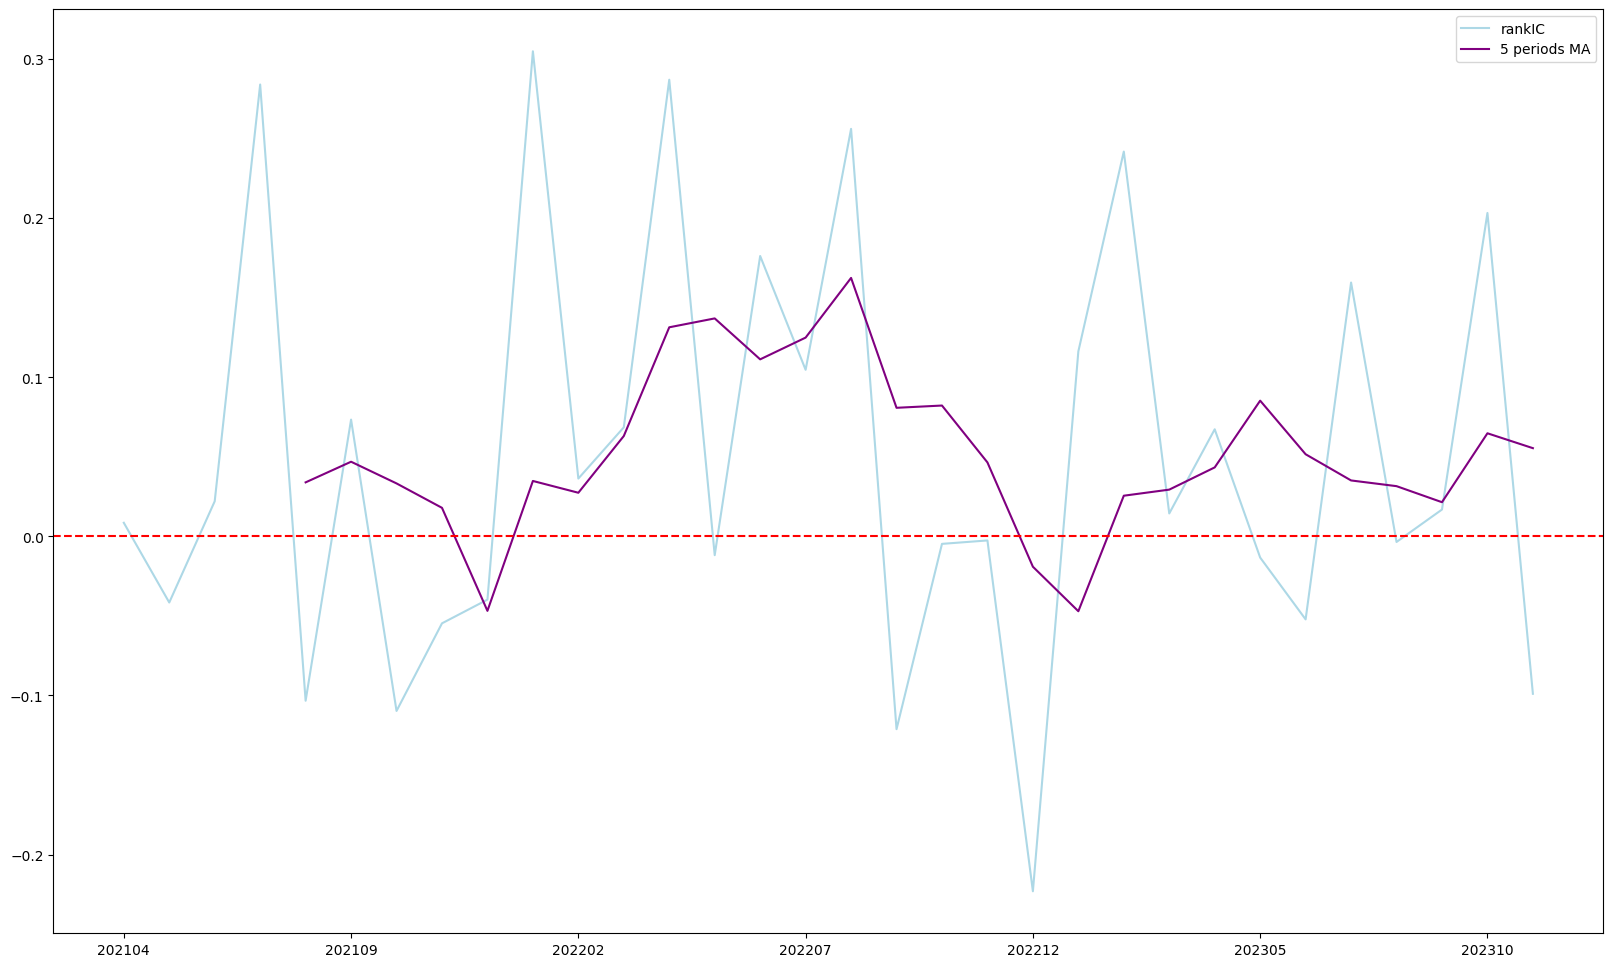

In [320]:
tk.plot_ICseries(ic, ma=5)

分层回测

In [385]:
#按横截面因子大小分组 从g1到g5因子呈升序
group_num = 5
factor_group = factor_df.reset_index()
factor_group = factor_group.melt(id_vars='month', value_name='factor')
factor_group['group'] = factor_group.groupby('month')['factor'].transform(lambda x: 
                                pd.qcut(x, group_num, labels=[f"g{i}" for i in range(1, group_num + 1)]))
factor_group 

,month,stkcd,factor,group
0,202104,000001,0.009439,g3
1,202105,000001,0.092931,g3
2,202106,000001,0.177872,g3
3,202107,000001,0.353532,g3
4,202108,000001,0.597582,g4
...,...,...,...,...
9268,202308,688981,1.031023,g5
9269,202309,688981,0.882533,g4
9270,202310,688981,0.950090,g5
9271,202311,688981,0.864323,g5


In [386]:
group_data = rm.reset_index().melt(id_vars='month', value_name='return')
group_data = pd.merge(factor_group, group_data, 'left', on=['month', 'stkcd'])
group_data = pd.merge(group_data, mv_df, 'left', on=['month', 'stkcd'])
#按时间-组别计算权重，为市值加权回报率做准备
total_value = group_data.groupby('month').apply(lambda x: x.groupby('group')['MkV_A'].sum()).reset_index()
total_value = total_value.melt(id_vars='month', value_name='total_value')
group_data = pd.merge(group_data, total_value, 'left', on=['month', 'group'])
group_data['weight'] = group_data['MkV_A'] / group_data['total_value']
group_data['weighted_return'] = group_data['weight'] * group_data['return']
group_data

,month,stkcd,factor,group,return,MkV_A,total_value,weight,weighted_return
0,202104,000001,0.009439,g3,0.055973,4.627481e+12,6.790864e+13,0.068143,0.003814
1,202105,000001,0.092931,g3,0.045135,4.627481e+12,4.479473e+13,0.103304,0.004663
2,202106,000001,0.177872,g3,-0.062601,4.627481e+12,4.398187e+13,0.105213,-0.006586
3,202107,000001,0.353532,g3,-0.208378,4.785288e+12,4.293104e+13,0.111465,-0.023227
4,202108,000001,0.597582,g4,0.005874,4.785288e+12,2.956296e+13,0.161868,0.000951
...,...,...,...,...,...,...,...,...,...
9268,202308,688981,1.031023,g5,0.056075,3.764489e+11,6.238664e+13,0.006034,0.000338
9269,202309,688981,0.882533,g4,-0.056969,3.764489e+11,5.129547e+13,0.007339,-0.000418
9270,202310,688981,0.950090,g5,0.119257,3.820940e+11,2.272011e+13,0.016817,0.002006
9271,202311,688981,0.864323,g5,-0.062009,3.820940e+11,6.141314e+13,0.006222,-0.000386


In [387]:
group_data.isna().any()

month              False
stkcd              False
factor             False
group              False
return             False
MkV_A              False
total_value        False
weight             False
weighted_return    False
dtype: bool

<Figure size 1200x800 with 0 Axes>

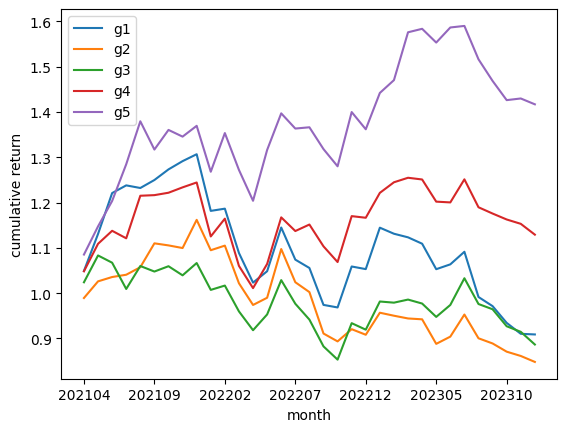

,年化复合收益率,年化波动率,最大回撤比列,夏普比率,卡玛比率
group,,,,,
g1,-0.034202,0.179163,-0.304566,-0.107039,-0.112297
g2,-0.058159,0.148175,-0.270023,-0.331507,-0.215384
g3,-0.042851,0.150689,-0.212343,-0.217901,-0.201800
g4,0.045151,0.159082,-0.187476,0.355013,0.240834
g5,0.135102,0.169904,-0.127263,0.830969,1.061593


In [388]:
#等权重加权
group_return = group_data.groupby('month').apply(lambda sub_df: sub_df.groupby('group')['return'].mean())
tk.grouped_backtest(group_return, 'monthly')


<Figure size 1200x800 with 0 Axes>

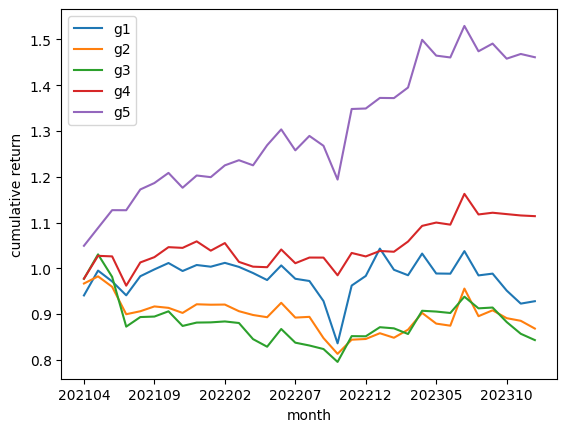

,年化复合收益率,年化波动率,最大回撤比列,夏普比率,卡玛比率
group,,,,,
g1,-0.026777,0.157660,-0.173784,-0.097199,-0.154084
g2,-0.050066,0.108790,-0.186960,-0.418665,-0.267788
g3,-0.060178,0.122514,-0.228077,-0.445165,-0.263849
g4,0.040004,0.098323,-0.070000,0.447113,0.571484
g5,0.147857,0.121548,-0.084150,1.198208,1.757062


In [389]:
#市值加权
group_return = group_data.groupby('month').apply(lambda sub_df: sub_df.groupby('group')['weighted_return'].sum())
tk.grouped_backtest(group_return, 'monthly')

FF3残差动量因子仅在最高的组别（前20%）表现出了单调性，显著优于其他组别